## Node participation vs other classic network properties

We compare node participation on maximal simplices with other more classical network properties of node centrality: hubs and closness centrality.  We do this for all connectomes:

* C. elegans (last stage) of *Witvliet et al:* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8756380/  
* Drosophila larva of *Winding et al., 2023* https://www.science.org/doi/10.1126/science.add9330 
* MICrONS data set of the *IARPA MICrONS mm^3 dataset* https://www.microns-explorer.org/cortical-mm3 
* The V5 version of the Blue Brain Project model of https://www.cell.com/fulltext/S0092-8674(15)01191-5

Metrics where precomputed in ```data_analysis/structure/code/compute_other_metrics.py```

In [1]:
import pickle 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats

In [2]:
# Load pre-computed simplex counts 
root="/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data"
connectomes=["Celegans", "Drosophila", "MICrONS","BBP"]

In [3]:
# Compute closeness and degree distributions.  
# Computing closeness is expensive for the BBP network.  So it's precomputed in compute_other_metrics.py
with open(f'{root}/other_node_metrics.pkl', 'rb') as f: 
    node_metrics=pickle.load(f)


# Plotting

In [4]:
# Font sizes and color schemes and labels
titlesize=8
labelsize=6
ticksize=6
marker_size=2
conversion=2.54
#conversion=1.5


cmap=plt.cm.Dark2
colors={
    'original':'indianred',#cmap(3), 
    'configuration_model':cmap(2), 
    'ER_shuffle':cmap(0), 
    'underlying_model':cmap(4), 
    'bishuffled_model':cmap(5), 
    'run_DD2':cmap(1)}
legend={
    'original':"Original", 
    'configuration_model':"CM", 
    'ER_shuffle':"ER", 
    'underlying_model':"Underlying", 
    'bishuffled_model':"Shuffle", 
    'run_DD2':"Distance"}
markers={
    'original':"o", 
    'configuration_model':"P", 
    'ER_shuffle':"*", 
    'underlying_model':"*", 
    'bishuffled_model':"*", 
    'run_DD2':"H"}

# Hubs and scale-free properties

We first check if the networks are scale-free and see where the nodes with highest node participation are in the degree distributions.  We consider all types of directed degreeds: in-degree, out-degree and total-degree

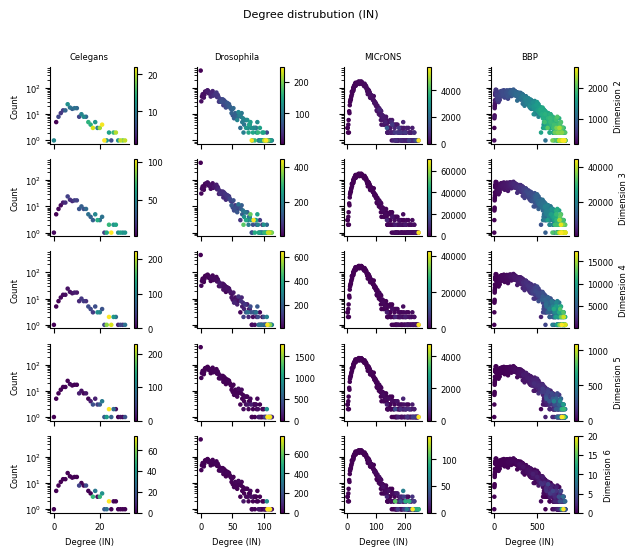

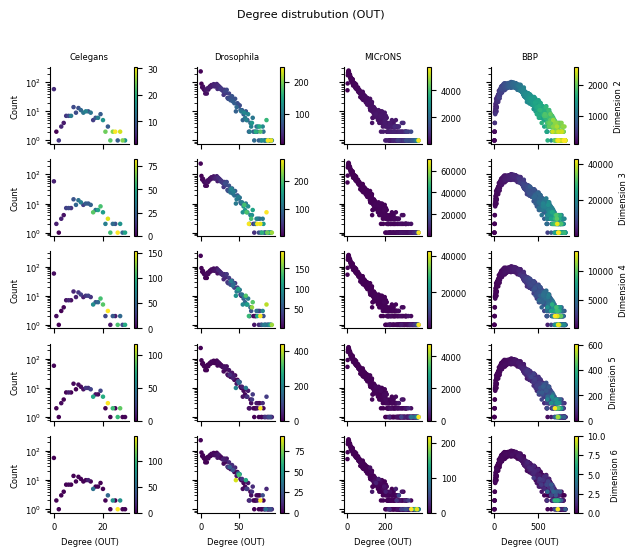

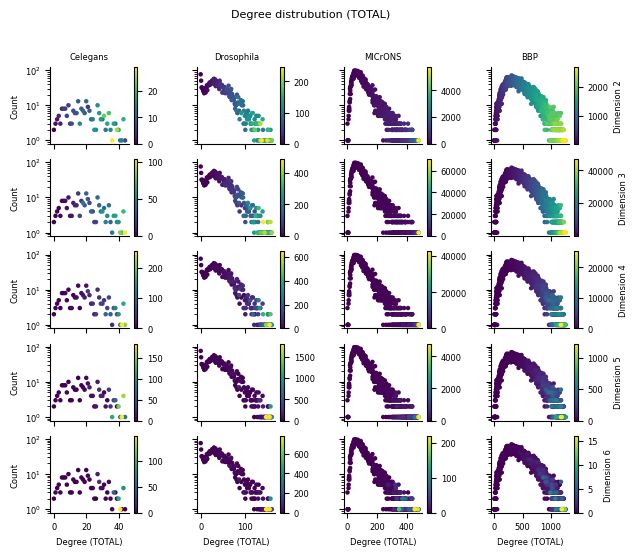

In [5]:
width=21*0.7/conversion
for deg_type in ["IN", "OUT", "TOTAL"]:
    fig, axs = plt.subplots(5,4, figsize=(width*1.2,width),sharey="row", sharex="col")
    fig.suptitle(f"Degree distrubution ({deg_type})", fontsize=titlesize)
    for j, conn in enumerate(connectomes):
        df_grp=node_metrics[conn].groupby(by=deg_type)
        df_ct=df_grp.count()
        df_mean=df_grp.mean()
        for i, dim in enumerate(np.arange(5)+2):
            par=df_mean[f"par_dim_{dim}"].to_numpy()
            order=np.argsort(par)
            plot=axs[i,j].scatter(np.arange(len(df_ct))[order], df_ct.iloc[:,0].to_numpy()[order], c=par[order], s=5)
            axs[i,j].set_yscale("log")
            #axs[i,j].set_xscale("log")
            cbar=plt.colorbar(plot,ax=axs[i,j])
            if j==3:
                cbar.set_label(label=f"Dimension {dim}", size=ticksize)
            cbar.ax.tick_params(labelsize=ticksize)
            axs[i,0].set_ylabel(f"Count", fontsize=labelsize)
        axs[0,j].set_title(f"{conn}", fontsize=labelsize)
        axs[-1,j].set_xlabel(f"Degree ({deg_type})", fontsize=labelsize)
        # Fixing axes 
    for ax in axs.flatten():
        ax.tick_params(axis='both', labelsize=ticksize)
        ax.spines[["top", "right"]].set_visible(False)

    plt.subplots_adjust(wspace=.5)
    fig.savefig(f"figs/{deg_type}_deg_hist_color_participation_all_dims.png", transparent=True, bbox_inches='tight')


Even though not all networks are scale free, we still consider as hubs those in the top 10% of the in/out-degree distributions and see what values of node participation these have relative to the rest of the population of nodes.  We take 10% rather than say 1% because the Celegans network is too small to consider a smaller threshold.

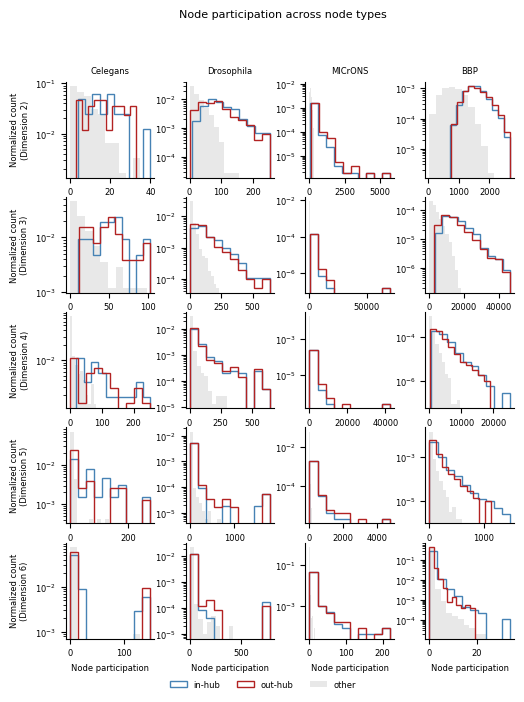

In [6]:
width=21*0.7/conversion
cnohub="lightgray"; cinhub="steelblue"; couthub="firebrick"
per=0.1
fig, axs = plt.subplots(5,4, figsize=(width,width*5/4),sharey=False, sharex=False)
fig.suptitle(f"Node participation across node types", fontsize=titlesize)
for j, conn in enumerate(connectomes):
    q=node_metrics[conn].quantile(1-per)
    df_in_hub=node_metrics[conn][node_metrics[conn]["IN"]>= q["IN"]]
    df_out_hub=node_metrics[conn][node_metrics[conn]["OUT"]>= q["OUT"]]
    mask=np.logical_and(node_metrics[conn]["IN"] < q["IN"], node_metrics[conn]["OUT"]< q["OUT"])
    df_nonhub=node_metrics[conn][mask]    
    for i, dim in enumerate(np.arange(5)+2):
        #_, bins=np.histogram(node_metrics[conn][f"par_dim_{dim}"])
        bins=None
        axs[i,j].hist(df_in_hub[f"par_dim_{dim}"], density=True, histtype="step", color=cinhub, bins=bins, label="in-hub")
        axs[i,j].hist(df_out_hub[f"par_dim_{dim}"], density=True, histtype="step", color=couthub, bins=bins, label="out-hub")
        axs[i,j].hist(df_nonhub[f"par_dim_{dim}"],density=True, histtype="bar",alpha=0.5,color=cnohub, bins=bins, label="other")
        axs[i,j].set_yscale("log")
        #axs[i,j].set_xscale("log")
        axs[i,0].set_ylabel(f"Normalized count\n(Dimension {dim})", fontsize=labelsize)
    axs[0,j].set_title(f"{conn}", fontsize=labelsize)
    axs[-1,j].set_xlabel(f"Node participation",fontsize=labelsize)

# Fixing axes 
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.spines[["top", "right"]].set_visible(False)

plt.subplots_adjust(wspace=.35)
axs[-1,1].legend(frameon=False,loc=4, bbox_to_anchor=(2,-0.6), ncol=3, fontsize=labelsize)

fig.savefig(f"figs/{deg_type}_hist_hubs_in_and_out_th_{per}.pdf", transparent=True, bbox_inches='tight')


# Closeness centrality

We compare node participation to closeness centrality, a classic centrality metric in network science.  See for example 

https://www.sciencedirect.com/topics/computer-science/closeness-centrality

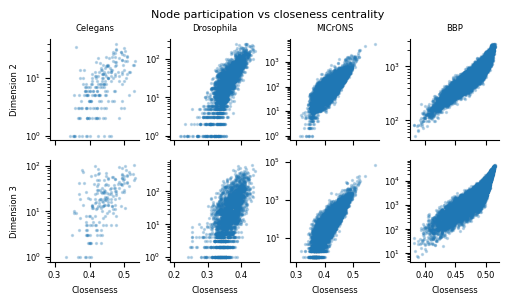

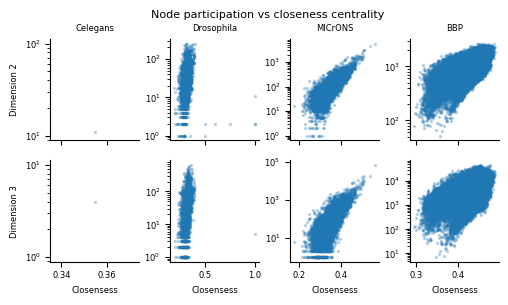

In [7]:
width=21*0.7/conversion
for cl_type in ["undirected", "directed"]:
    fig, axs = plt.subplots(2,4, sharex="col", figsize=(width,width/2))
    fig.suptitle(f"Node participation vs closeness centrality", fontsize=titlesize)
    for j, conn in enumerate(connectomes):
        for i, dim in enumerate(np.arange(2)+2):
            x=node_metrics[conn][f"closeness_{cl_type}"]
            y=node_metrics[conn][f"par_dim_{dim}"]
            axs[i,j].scatter(x[x!=0], y[x!=0], s=2, alpha=0.25, rasterized=True)
            axs[i,0].set_ylabel(f"Dimension {dim}", fontsize=labelsize)
            axs[i,j].set_yscale("log")
        axs[0,j].set_title(f"{conn}", fontsize=labelsize)
        axs[-1,j].set_xlabel(f"Closensess", fontsize=labelsize)
    
    # Fixing axes 
    for ax in axs.flatten():
        ax.tick_params(axis='both', labelsize=ticksize)
        ax.spines[["top", "right"]].set_visible(False)
    plt.subplots_adjust(wspace=.35)
    
    #plt.tight_layout()
    fig.savefig(f"figs/closeness_{cl_type}_vs_participation.pdf", transparent=True, bbox_inches='tight')